## Imports

In [534]:
import io
import pathlib
import pickle
import re
import pandas as pd
pd.set_option('display.max_rows', None)

import ads
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
import galstreams
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from astropy.stats import median_absolute_deviation as MAD
from gala.units import galactic
from helpers import (
    get_default_track_for_stream,
    get_frame_from_points,
    get_full_galstreams_poly,
    get_isochrone,
    make_ibata_poly_nodes,
    run_orbit_fit,
)
from pyia import GaiaData
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import minimize
from tqdm.auto import tqdm

from astropy.table import Table, vstack, hstack, join, unique

from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" # Select Data Release 3


%matplotlib inline

## Stream census

In [738]:
mwstreams = galstreams.MWStreams(implement_Off=True)

Initializing galstreams library from master_log... 


In [739]:
mwstreams

{'20.0-1-M18': <galstreams.core.Track6D at 0x7fb3cb07a610>,
 '300S-F18': <galstreams.core.Track6D at 0x7fb3cfe84580>,
 'AAU-ATLAS-L21': <galstreams.core.Track6D at 0x7fb3ca5552e0>,
 'AAU-AliqaUma-L21': <galstreams.core.Track6D at 0x7fb3cb2e8520>,
 'ACS-R21': <galstreams.core.Track6D at 0x7fb3ca56bb50>,
 'ATLAS-I21': <galstreams.core.Track6D at 0x7fb3cc534520>,
 'ATLAS-I24': <galstreams.core.Track6D at 0x7fb3cc7e78b0>,
 'Acheron-G09': <galstreams.core.Track6D at 0x7fb3ca56b880>,
 'Alpheus-G13': <galstreams.core.Track6D at 0x7fb3ce691070>,
 'Aquarius-W11': <galstreams.core.Track6D at 0x7fb3cb8030a0>,
 'C-10-I24': <galstreams.core.Track6D at 0x7fb3cb90f400>,
 'C-11-I24': <galstreams.core.Track6D at 0x7fb3cb90f1f0>,
 'C-12-I24': <galstreams.core.Track6D at 0x7fb3ce691d30>,
 'C-13-I24': <galstreams.core.Track6D at 0x7fb3ce273070>,
 'C-19-I21': <galstreams.core.Track6D at 0x7fb3ce273160>,
 'C-19-I24': <galstreams.core.Track6D at 0x7fb3ce6912e0>,
 'C-20-I24': <galstreams.core.Track6D at 0x7fb

In [4]:
gnames = list(mwstreams.keys())
print(len(gnames))

141


In [5]:
mwstreams.summary.columns

Index(['Imp', 'On', 'TrackName', 'Name', 'TrackRefs', 'TrackRefsLatex',
       'Notes', 'from-Members', 'width_phi2', 'width_phi2_Ref',
       'width_pm_phi1_cosphi2', 'width_pm_phi1_cosphi2_Ref', 'width_pm_phi2',
       'width_pm_phi2_Ref', 'total_v_sigma', 'total_v_sigma_Ref', 'Lv_stream',
       'L_Ref', 'width_comment', 'length', 'ra_o', 'dec_o', 'distance_o',
       'ra_f', 'dec_f', 'distance_f', 'ra_mid', 'dec_mid', 'distance_mid',
       'ra_pole', 'dec_pole', 'InfoFlags', 'has_empirical_track', 'has_D',
       'has_pm', 'has_vrad', 'DiscoveryRefs', 'ID'],
      dtype='object')

In [6]:
mwstreams.summary

,Imp,On,TrackName,Name,TrackRefs,TrackRefsLatex,Notes,from-Members,width_phi2,width_phi2_Ref,...,distance_mid,ra_pole,dec_pole,InfoFlags,has_empirical_track,has_D,has_pm,has_vrad,DiscoveryRefs,ID
TrackName,,,,,,,,,,,,,,,,,,,,,
20.0-1-M18,po,True,20.0-1-M18,20.0-1,mateu2018,Mateu2018,-,0,1.80,Riley2020,...,26.839948,235.758575,38.821881,0000,0,0,0,0,Mateu2018,1
300S-F18,st,True,300S-F18,300S,fu2018,Fu2018,-,0,0.40,Fu2018,...,15.929409,308.056470,72.509388,1101,1,1,0,1,"NiedersteOstholt2009,Simon2011",2
AAU-ATLAS-L21,st,True,AAU-ATLAS-L21,AAU-ATLAS,li2021,Li2021,-,1,0.30,Li2021,...,21.478244,74.259067,47.933124,1111,1,1,1,1,Koposov2014,3
AAU-AliqaUma-L21,st,True,AAU-AliqaUma-L21,AAU-AliqaUma,li2021,Li2021,-,1,0.26,Li2021,...,21.981943,74.259067,47.933124,1111,1,1,1,1,Shipp2018,4
ACS-R21,st,True,ACS-R21,ACS,ramos2021,Ramos2021,-,0,2.10,Riley2020,...,11.700000,212.301639,-4.733141,1110,1,1,1,0,Grillmair2006_acs,5
ATLAS-I21,st,False,ATLAS-I21,AAU-ATLAS,ibata2021,Ibata2021,-,1,0.35,from-Members,...,24.642130,80.544842,44.626077,1111,1,1,1,1,Koposov2014,
ATLAS-I24,st,False,ATLAS-I24,AAU-ATLAS,ibata2024,Ibata2024,-,1,0.41,from-Members,...,1.000000,76.343232,47.439685,1111,1,1,1,1,Koposov2014,
Acheron-G09,ep,True,Acheron-G09,Acheron,grillmair2009,Grillmair2009,-,0,0.40,Riley2020,...,3.656382,142.339428,49.453184,0000,0,0,0,0,Grillmair2009,6
Alpheus-G13,st,True,Alpheus-G13,Alpheus,grillmair2013,Grillmair2013,-,0,1.40,Riley2020,...,1.800264,301.571407,4.280719,1100,1,1,0,0,Grillmair2013,7


In [7]:
gnames = np.unique(mwstreams.summary['Name'])

In [8]:
gnames

array(['20.0-1', '300S', 'AAU-ATLAS', 'AAU-AliqaUma', 'ACS', 'Acheron',
       'Alpheus', 'Aquarius', 'C-10', 'C-11', 'C-12', 'C-13', 'C-19',
       'C-20', 'C-22', 'C-23', 'C-24', 'C-25', 'C-4', 'C-5', 'C-7', 'C-8',
       'C-9', 'Cetus', 'Cetus-New', 'Cetus-Palca', 'Cocytos', 'Corvus',
       'Elqui', 'Eridanus', 'Fimbulthul', 'GD-1', 'Gaia-1', 'Gaia-10',
       'Gaia-11', 'Gaia-12', 'Gaia-2', 'Gaia-3', 'Gaia-4', 'Gaia-5',
       'Gaia-6', 'Gaia-7', 'Gaia-8', 'Gaia-9', 'Gunnthra', 'Hermus',
       'Hrid', 'Hydrus', 'Hyllus', 'Indus', 'Jet', 'Jhelum', 'Jhelum-a',
       'Jhelum-b', 'Kshir', 'Kwando', 'LMS-1', 'Leiptr', 'Lethe', 'M2',
       'M3-Svol', 'M30', 'M5', 'M68', 'M68-Fjorm', 'M92', 'Molonglo',
       'Monoceros', 'Murrumbidgee', 'NGC1261', 'NGC1261a', 'NGC1261b',
       'NGC1851', 'NGC2298', 'NGC2808', 'NGC288', 'NGC3201',
       'NGC3201-Gjoll', 'NGC5053', 'NGC5466', 'NGC6101', 'NGC6362',
       'NGC6397', 'NGC7492', 'New-1', 'New-10', 'New-11', 'New-12',
       'New-13', 'N

In [672]:
names = ['20.0-1', '300S', 'ATLAS-Aliqa Uma', 'Acheron',
       'Alpheus', 'Aquarius', 'C-10', 'C-11', 'C-12', 'C-13', 'C-19',
       'C-20', 'C-22', 'C-23', 'C-24', 'C-25', 'C-4', 'C-5', 'C-7', 'C-8',
       'C-9', 'Cetus-Palca', 'Cocytos', 'Corvus',
       'Elqui', 'Eridanus', 'GD-1', 'Gaia-1', 
       'Gaia-11', 'Gaia-12', 'Gaia-2', 'Gaia-3', 'Gaia-4', 'Gaia-5',
       'Gaia-6', 'Gaia-7', 'Gaia-8', 'Gaia-9', 'Gunnthra', 'Hermus',
       'Hrid', 'Hydrus', 'Hyllus', 'Indus', 'Jet', 'Jhelum',
       'Kshir', 'Kwando', 'Wukong', 'Leiptr', 'Lethe', 'M2',
       'M3', 'M30', 'M5', 'M68', 'M92', 'Molonglo',
       'Murrumbidgee', 'NGC 1261',
       'NGC 1851', 'NGC 2298', 'NGC 2808', 'NGC 288', 'NGC 3201',
       'NGC 5053', 'NGC 5466', 'NGC 6101', 'NGC 6362',
       'NGC 6397', 'NGC 7492', 'New-1', 'New-10', 'New-11', 'New-12',
       'New-13', 'New-14', 'New-15', 'New-16', 'New-17', 'New-18',
       'New-19', 'New-2', 'New-20', 'New-21', 'New-22', 'New-23',
       'New-24', 'New-25', 'New-26', 'New-27', 'New-3', 'New-4', 'New-5',
       'New-6', 'New-7', 'New-8', 'New-9', 'Omega Centauri',
       'Ophiuchus', 'Orinoco', 'Orphan-Chenab', 'PS1-A', 'PS1-B', 'PS1-C',
       'PS1-D', 'PS1-E', 'Palomar 13', 'Palomar 15', 'Palomar 5',  'Parallel',
       'Pegasus', 'Perpendicular', 'Phlegethon', 'Phoenix', 'Ravi',
       'SGP-S', 'Sagittarius', 'Sangarius', 'Scamander', 'Slidr',
       'Spectre', 'Styx', 'Sylgr', 'Triangulum', 'Tucana III',
       'Turbio', 'Turranburra', 'Wambelong', 'Willka Yaku', 'Ylgr']

In [673]:
# removed ebs, acs, yangtze as likely disk structures
len(names)

131

In [675]:
alt_names = {'300S': 'Gaia-10', 'Wukong': 'LMS-1', 'M2': 'NGC 7089', 'M3': 'Svol', 'M30':'NGC 7099', 'M68': 'Fjorm',
             'NGC 3201': 'Gjoll', 'Omega Centauri': 'Fimbulthul', 'Triangulum': 'Triangulum-Pisces'}

## Published stream catalogs

### Catalog formats

#### Ibata

In [687]:
ti = Table.read('../data/members/input/ibata_members.txt', format='ascii')

# make it fits friendly
ti.rename_column('(B-R)', 'BP_RP')

In [688]:
ti

Gaia,RAdeg,DEdeg,plx,pmRA,pmDE,Gmag,BP_RP,VHel,e_VHel,r_VHel,Stream
,deg,deg,mas,mas / yr,mas / yr,mag,mag,km / s,km / s,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
2746748683780680704,0.131771,8.022269,-0.523,-0.338,1.39,19.35,0.74,0.0,300.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
6494334664332365056,359.889559,-59.460237,-0.014,-0.25,-1.515,19.57,0.75,0.0,300.0,0,87


In [689]:
ti_key = Table.read('../data/members/input/ibata_key_trim.txt', format='ascii.commented_header', delimiter='\t')

In [690]:
ti_key

s _ID,Name,Sample,alpha _0,alpha _pole,delta _pole,n,n _v,M _sstarf,angl0[Fe/H]angr0,References,Remarks
int64,str12,int64,float64,float64,float64,int64,int64,str7,float64,str7,str39
1,C-20,1,0.561,275.038,-30.9,29,8,1200,-2.93,(1),...
...,...,...,...,...,...,...,...,...,...,...,...
86,Jhelum,1,355.231,5.299,37.216,986,160,"17,000",-2.12,(9),...
87,Tuc-3,0,359.15,176.704,-30.396,102,34,"12,000",-2.49,(17),...


In [691]:
# populate stream names in the member table
col_name = []
for i in range(len(ti)):
    col_name += [ti_key['Name'][ti['Stream'][i]-1]]

In [692]:
ti['name'] = col_name

In [693]:
ti

Gaia,RAdeg,DEdeg,plx,pmRA,pmDE,Gmag,BP_RP,VHel,e_VHel,r_VHel,Stream,name
,deg,deg,mas,mas / yr,mas / yr,mag,mag,km / s,km / s,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str12
2746748683780680704,0.131771,8.022269,-0.523,-0.338,1.39,19.35,0.74,0.0,300.0,0,1,C-20
...,...,...,...,...,...,...,...,...,...,...,...,...
6494334664332365056,359.889559,-59.460237,-0.014,-0.25,-1.515,19.57,0.75,0.0,300.0,0,87,Tuc-3


In [694]:
ti.write('../data/members/input/ibata_apj_labeled.fits', overwrite=True)

In [669]:
print(list(np.unique(ti['name'])), np.size(np.unique(ti['name'])))

['ATLAS', 'C-10', 'C-11', 'C-12', 'C-13', 'C-19', 'C-20', 'C-22', 'C-23', 'C-24', 'C-25', 'C-7', 'C-9', 'Fimbulthul', 'Fimbulthul-S', 'Fjorm', 'GD-1', 'Gaia-1', 'Gaia-10', 'Gaia-11', 'Gaia-12', 'Gaia-6', 'Gaia-7', 'Gaia-8', 'Gaia-9', 'Gjoll', 'Hrid', 'Hydrus', 'Indus', 'Jhelum', 'Kshir', 'Kwando', 'LMS-1', 'Leiptr', 'M5', 'M92', 'NGC 1261', 'NGC 1261a', 'NGC 1261b', 'NGC 1851', 'NGC 2298', 'NGC 2808', 'NGC 288', 'NGC5466', 'NGC6101', 'NGC6397', 'NGC7089', 'NGC7099', 'NGC7492', 'New-1', 'New-10', 'New-11', 'New-12', 'New-13', 'New-14', 'New-15', 'New-16', 'New-17', 'New-18', 'New-19', 'New-2', 'New-20', 'New-21', 'New-22', 'New-23', 'New-24', 'New-25', 'New-26', 'New-27', 'New-3', 'New-4', 'New-5', 'New-6', 'New-7', 'New-8', 'New-9', 'Ophiuchus', 'Orphan', 'Pal-5', 'Phlegethon', 'Phoenix', 'SGP-S', 'Slidr', 'Svol', 'Sylgr', 'Tuc-3', 'Ylgr'] 87


In [713]:
dict_ibata = {'ATLAS': 'ATLAS-Aliqa Uma', 'C-10':'C-10', 'C-11':'C-11', 'C-12':'C-12', 'C-13':'C-13',
              'C-19':'C-19', 'C-20':'C-20', 'C-22':'C-22', 'C-23':'C-23', 'C-24':'C-24', 'C-25':'C-25',
              'C-7':'C-7', 'C-9':'C-9', 'Fimbulthul': 'Omega Centauri', 'Fimbulthul-S':'Omega Centauri',
              'Fjorm':'M68',
              'GD-1':'GD-1', 'Gaia-1':'Gaia-1', 'Gaia-10':'300S', 'Gaia-11':'Gaia-11', 'Gaia-12':'Gaia-12',
              'Gaia-6':'Gaia-6', 'Gaia-7':'Gaia-7', 'Gaia-8':'Gaia-8', 'Gaia-9':'Gaia-9', 'Gjoll':'NGC 3201',
              'Hrid':'Hrid', 'Hydrus':'Hydrus', 'Indus':'Indus', 'Jhelum':'Jhelum', 'Kshir':'Kshir',
              'Kwando':'Kwando', 'LMS-1':'Wukong', 'Leiptr':'Leiptr', 'M5':'M5', 'M92':'M92', 'NGC1261':'NGC 1261',
              'NGC 1261a':'NGC 1261', 'NGC 1261b':'NGC 1261', 'NGC 1851':'NGC 1851', 'NGC 2298':'NGC 2298',
              'NGC 2808':'NGC 2808', 'NGC 288':'NGC 288', 'NGC5466':'NGC 5466', 'NGC6101':'NGC 6101',
              'NGC6397':'NGC 6397', 'NGC7089':'M2', 'NGC7099':'M30', 'NGC7492':'NGC 7492',
              'New-1':'New-1', 'New-10':'New-10', 'New-11':'New-11', 'New-12':'New-12', 'New-13':'New-13',
              'New-14':'New-14', 'New-15':'New-15', 'New-16':'New-16', 'New-17':'New-17', 'New-18':'New-18',
              'New-19':'New-19', 'New-2':'New-2', 'New-20':'New-20', 'New-21':'New-21', 'New-22':'New-22',
              'New-23':'New-23', 'New-24':'New-24', 'New-25':'New-25', 'New-26':'New-26', 'New-27':'New-27',
              'New-3':'New-3', 'New-4':'New-4', 'New-5':'New-5', 'New-6':'New-6', 'New-7':'New-7',
              'New-8':'New-8', 'New-9':'New-9', 'Ophiuchus':'Ophiuchus', 'Orphan':'Orphan-Chenab',
              'Pal-5':'Palomar 5', 'Phlegethon':'Phlegethon', 'Phoenix':'Phoenix', 'SGP-S':'SGP-S', 'Slidr':'Slidr',
              'Svol':'M3', 'Sylgr':'Sylgr', 'Tuc-3':'Tucana III', 'Ylgr':'Ylgr'}

In [714]:
dict_invibata = {'ATLAS-Aliqa Uma':['ATLAS'], 'C-10':['C-10'], 'C-11':['C-11'], 'C-12':['C-12'], 'C-13':['C-13'],
              'C-19':['C-19'], 'C-20':['C-20'], 'C-22':['C-22'], 'C-23':['C-23'], 'C-24':['C-24'], 'C-25':['C-25'],
              'C-7':['C-7'], 'C-9':['C-9'], 'Omega Centauri':['Fimbulthul', 'Fimbulthul-S'], 'M68':['Fjorm'],
              'GD-1':['GD-1'], 'Gaia-1':['Gaia-1'], '300S':['Gaia-10'], 'Gaia-11':['Gaia-11'], 'Gaia-12':['Gaia-12'],
              'Gaia-6':['Gaia-6'], 'Gaia-7':['Gaia-7'], 'Gaia-8':['Gaia-8'], 'Gaia-9':['Gaia-9'],
                 'NGC 3201':['Gjoll'],
              'Hrid':['Hrid'], 'Hydrus':['Hydrus'], 'Indus':['Indus'], 'Jhelum':['Jhelum'], 'Kshir':['Kshir'],
              'Kwando':['Kwando'], 'Wukong':['LMS-1'], 'Leiptr':['Leiptr'], 'M5':['M5'], 'M92':['M92'],
                 'NGC 1261':['NGC1261'],
              'NGC 1261':['NGC 1261a', 'NGC 1261b'], 'NGC 1851':['NGC 1851'], 'NGC 2298':['NGC 2298'],
              'NGC 2808':['NGC 2808'], 'NGC 288':['NGC 288'], 'NGC 5466':['NGC5466'], 'NGC 6101':['NGC6101'],
              'NGC 6397':['NGC6397'], 'M2':['NGC7089'], 'M30':['NGC7099'], 'NGC 7492':['NGC7492'],
              'New-1':['New-1'], 'New-10':['New-10'], 'New-11':['New-11'], 'New-12':['New-12'], 'New-13':['New-13'],
              'New-14':['New-14'], 'New-15':['New-15'], 'New-16':['New-16'], 'New-17':['New-17'],
                 'New-18':['New-18'],
              'New-19':['New-19'], 'New-2':['New-2'], 'New-20':['New-20'], 'New-21':['New-21'], 'New-22':['New-22'],
              'New-23':['New-23'], 'New-24':['New-24'], 'New-25':['New-25'], 'New-26':['New-26'], 
                 'New-27':['New-27'], 'New-3':['New-3'], 'New-4':['New-4'], 'New-5':['New-5'], 'New-6':['New-6'],
                 'New-7':['New-7'],
              'New-8':['New-8'], 'New-9':['New-9'], 'Ophiuchus':['Ophiuchus'], 'Orphan-Chenab':['Orphan'],
              'Palomar 5':['Pal-5'],
              'Phlegethon':['Phlegethon'], 'Phoenix':['Phoenix'], 'SGP-S':['SGP-S'], 'Slidr':['Slidr'],
                 'M3':['Svol'], 'Sylgr':['Sylgr'], 'Tucana III':['Tuc-3'], 'Ylgr':['Ylgr']}

#### S5

In [78]:
ts = Table.read('../data/members/input/s5_shipp.txt', format='ascii.commented_header', delimiter=',')

In [79]:
np.unique(ts['Stream'])

ATLAS
Aliqa Uma
Chenab
Elqui
Indus
Jhelum-a
Jhelum-b
Phoenix
Tucana III
Turranburra


In [409]:
dict_invshipp = {'ATLAS-Aliqa Uma':['ATLAS', 'Aliqa Uma'], 'Orphan-Chenab':['Chenab'], 'Elqui':['Elqui'],
                'Indus':['Indus'], 'Jhelum':['Jhelum-a', 'Jhelum-b'], 'Phoenix':['Phoenix'],
                 'Tucana III': ['Tucana III'], 'Turranburra':['Turranburra']}

In [99]:
ts5 = Table.read('../data/members/input/s5_pdr1.fits')

In [103]:
print(ts5.colnames)

['vel1', 'vel99', 'vel50', 'vel16', 'vel84', 'vel_std', 'vel_skew', 'vel_kurt', 'feh1', 'feh99', 'feh50', 'feh16', 'feh84', 'feh_std', 'feh_skew', 'feh_kurt', 'logg1', 'logg99', 'logg50', 'logg16', 'logg84', 'logg_std', 'logg_skew', 'logg_kurt', 'teff1', 'teff99', 'teff50', 'teff16', 'teff84', 'teff_std', 'teff_skew', 'teff_kurt', 'vel_calib', 'vel_calib_std', 'feh_calib_std', 'redchisq_1700d', 'chisq_1700d', 'absdev_1700d', 'ra', 'dec', 'name', 'field', 'fileinfo', 'utmjd', 'sn_1700d', 'moon_dist', 'moon_phase', 'moon_alt', 'qso_flag_wise', 'priority', 'primary', 'good_star_pb', 'good_star', 'ebv', 'gaia_source_id', 'parallax', 'parallax_error', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'phot_bp_rp_excess_factor', 'decam_g', 'decam_r', 'decam_i', 'decam_z', 'decam_phot_src_bits', 'flux_w1', 'flux_w2', 'dflux_w1', 'dflux_w2', 'u_skm', 'g_skm', 'r_skm', 'i_skm', 'z_skm', 'starhorse_dist05', 'starhorse_dist16', 'starhorse_dis

In [447]:
len(ts5), np.size(np.unique(ts5['gaia_source_id']))

(31777, 29596)

In [460]:
# keep smallest rv uncertainty if there are duplicate S5 measurements
ts5.sort(['gaia_source_id', 'vel_calib_std'])

In [462]:
ts5 = ts5[ts5['gaia_source_id']>0]

In [464]:
len(ts5), np.size(np.unique(ts5['gaia_source_id']))

(31774, 29595)

In [469]:
# set up unique table for S5
ts5_unique = Table(names=ts5.colnames, dtype=[col.dtype for col in ts5.columns.values()])

# add first row
ts5_unique.add_row(ts5[0])

# add additional non-duplicate rows
for row in ts5[:]:
    if row['gaia_source_id'] not in ts5_unique['gaia_source_id']:
        ts5_unique.add_row(row)

In [470]:
ts5_unique

vel1,vel99,vel50,vel16,vel84,vel_std,vel_skew,vel_kurt,feh1,feh99,feh50,feh16,feh84,feh_std,feh_skew,feh_kurt,logg1,logg99,logg50,logg16,logg84,logg_std,logg_skew,logg_kurt,teff1,teff99,teff50,teff16,teff84,teff_std,teff_skew,teff_kurt,vel_calib,vel_calib_std,feh_calib_std,redchisq_1700d,chisq_1700d,absdev_1700d,ra,dec,name,field,fileinfo,utmjd,sn_1700d,moon_dist,moon_phase,moon_alt,qso_flag_wise,priority,primary,good_star_pb,good_star,ebv,gaia_source_id,parallax,parallax_error,pmra,pmdec,pmra_error,pmdec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_bp_rp_excess_factor,decam_g,decam_r,decam_i,decam_z,decam_phot_src_bits,flux_w1,flux_w2,dflux_w1,dflux_w2,u_skm,g_skm,r_skm,i_skm,z_skm,starhorse_dist05,starhorse_dist16,starhorse_dist50,starhorse_dist84,starhorse_dist95
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes19,bytes19,bytes50,float64,float64,float64,float64,float64,int64,int64,bool,float64,bool,float32,int64,float64,float32,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int64,float32,float32,float32,float32,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32
-23.31359954143605,-8.756495149254244,-15.626902796019715,-18.572225443133807,-12.747792137739602,3.0359543296526197,-0.18177735016734506,0.5916113173022581,-2.4905612204371397,-0.1934966650600251,-1.1445242320021234,-1.6276738978265701,-0.694263108007799,0.46332786622053423,-0.31707516873330777,0.17015899119886013,2.442036442631391,6.107191009374366,3.977045092238729,3.275003471195371,4.936847122606556,0.8380839441116006,0.47527341917552535,-0.1289139699491635,4725.332930367925,5485.0119068497015,5105.022462031342,4944.299771896717,5268.047071208985,163.41971839802977,-0.003985805509777934,-0.00174742510396797,-16.736902796019717,3.971604311222191,0.5930596687622839,1.022505353202758,2063.4158027631656,0.12862647111096515,322.48397916666664,11.18388888888889,1742742766298119296,calib-field-NGC7078,data_190219/data_poly1/calib-NGC7078long_ccd2.fits,58372.3758958682,5.069097995758057,142.22166416871673,3.822481393814087,4.987549700349996,0,9,True,0.9150874282802263,True,0.097966,1742742766298119296,0.4418930249341658,0.024260819,-4.647146937912815,-5.082900117193797,0.024269573,0.020787226,14.675701,15.171499,14.01311,1.2342619,15.304460525512695,14.579129219055176,0.0,14.207555770874023,1154,9341.9795,8792.727,17.648684,42.758644,0.0,0.0,0.0,0.0,0.0,1.7295042,1.8554925,2.1785924,2.4483414,3.0140736
5.7198390295406405,8.50281035385885,7.096515361812884,6.50377854308244,7.691386939718767,0.599091748749346,0.02625768962298712,-0.02750793779640759,-0.0021990227327961798,0.318599280615096,0.1769359165558943,0.1010739766267958,0.2388577993548452,0.06995082952757609,-0.31852384359296426,0.15654871096198075,3.843739196374909,4.666415795747771,4.25965325218151,4.098032724016598,4.421943512546774,0.1705676982318585,-0.04088241456281753,0.34973772259498004,5342.170877313729,5734.233513680751,5493.052479832419,5438.583633652032,5555.5103001490725,71.40646179364506,0.823521572784412,2.3260586347194145,5.9865153618128835,1.0162990050484515,0.0895370617952974,0.9742595570469208,1977.7469008052492,0.045731324578533905,322.7003916666667,11.356647222222223,1742751669765382912,calib-field-NGC7078,data_190219/data_poly1/calib-NGC7078long_ccd2.fits,58372.3758958682,14.731839179992676,142.23885694997156,3.822481393814087,4.987549700349996,0,8,True,0.9999980058493754,True,0.095934,1742751669765382912,2.2897126411004383,0.017076477,-20.52296963835292,-4.160497482297365,0.016591307,0.011900352,12.092466,12.5249815,11.498766,1.2141911,12.602761268615723,12.030552864074707,0.0,11.858736038208008,1154,75002.59,70062.46,44.16404,91.

In [471]:
len(ts5_unique), np.size(np.unique(ts5_unique['gaia_source_id']))

(29595, 29595)

In [584]:
ts5_unique.write('../data/members/input/s5_unique.fits', overwrite=True)

#### Jhelum Awad

In [140]:
ta = Table.read('../data/members/input/jhelum_awad.txt', format='ascii', delimiter='\t')

In [142]:
print(ta.colnames)

['Gaia ID (Gaia DR3)', 'RA (ICRS)', 'Dec (ICRS)', 'μα (mas/ yr)', 'μδ (mas/ yr)', '(BP\u2005−\u2005RP)0 (mag)', 'G0 (mag)', 'ϖ (″)', 'ϖ/δϖ', 'vrad (km/s)', '[Fe/H]', 'FeHerr']


#### OC Koposov

In [157]:
toc = Table.read('../data/members/input/oc_koposov.fits')

In [160]:
toc

origin,source_id,ra,dec,fi1,fi2,rv_gsr,rv,erv,pmfi1,pmfi2,epmfi1,epmfi2,drv,dpm1,dpm2,pmra,pmdec,bp_corr,rp_corr,g_corr,cmdsel
bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,bool
S5,3888500490279502464,155.87168333333335,15.861266666666667,83.38185637615942,1.9209781846689513,121.2445939551174,219.7871593430457,1.2896948430867021,0.36040719845296343,1.2269233610245514,0.058737001474884885,0.042464280702432446,3.7238807149000053,0.0281440550839252,0.058812354320537885,-1.2784678139306027,0.02746509180760463,16.130219,14.936237,15.617935,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
APOGEE,6459095870713918336,323.376860177594,-57.460194913704576,-54.156774756786525,2.136330298250865,-191.6635109637876,-127.57266998291016,0.11691000312566757,2.386258659537896,1.2907101906334788,0.021887188706016605,0.020877611037796583,-0.050102542611483614,-0.09718854224661255,0.02168889942985408,0.25313183028370134,-2.701127072709081,15.689341,14.261924,15.040485,True
APOGEE,6459088552089593088,324.1005296688977,-57.396205276782034,-54.36663745996325,2.4708506400140644,-193.55519762144044,-129.51620483398438,0.15651699900627136,2.450724935163725,1.2905748470487866,0.024784637887625673,0.02430124991709496,-2.178886412194373,-0.021190476090612087,0.026321883727020712,0.25672336969937115,-2.757848664288604,15.92977,14.558241,15.312277,True


In [159]:
print(toc.colnames)

['origin', 'source_id', 'ra', 'dec', 'fi1', 'fi2', 'rv_gsr', 'rv', 'erv', 'pmfi1', 'pmfi2', 'epmfi1', 'epmfi2', 'drv', 'dpm1', 'dpm2', 'pmra', 'pmdec', 'bp_corr', 'rp_corr', 'g_corr', 'cmdsel']


In [574]:
print(list(toc['origin']))

['S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5

In [572]:
np.size(np.unique(toc['source_id']))

357

In [576]:
# keep smallest rv uncertainty when duplicates available
toc.sort(['source_id', 'erv'])

In [577]:
# set up unique table
toc_unique = Table(names=toc.colnames, dtype=[col.dtype for col in toc.columns.values()])

# add first row
toc_unique.add_row(toc[0])

# add additional non-duplicate rows
for row in toc[:]:
    if row['source_id'] not in toc_unique['source_id']:
        toc_unique.add_row(row)

In [579]:
len(toc_unique), np.size(np.unique(toc_unique['source_id']))

(357, 357)

In [585]:
toc_unique.write('../data/members/input/oc_koposov_unique.fits', overwrite=True)

#### Spectre Chandra

In [189]:
tspec = Table.read('../data/members/input/spectre_chandra_trim.txt', format='ascii', delimiter='\t')

In [191]:
tspec

source_id,ra,dec,PSg,snr,Vr,Vr_err,Teff,Teff_err,logg,logg_err,feh,feh_err,afe,afe_err
int64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64
1491676299777912064,217.162,42.568,16.8,13.3,-139.4,0.2,5150,20,2.6,0.1,-1.51,0.05,0.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493316732469979136,218.035,43.452,18.7,2.4,-147.5,1.8,5520,40,3.2,0.1,-2.78,0.29,0.2,0.2
1493037765754139136,218.634,42.686,18.8,2.8,-147.2,1.1,5670,40,3.6,0.1,-1.72,0.18,0.3,0.2


#### Jet Ferguson

In [221]:
tj = Table.read('../data/members/input/jet_ferguson.fits')

In [224]:
tj

DELVE,Gaia,RAdeg,DEdeg,g0mag,r0mag,pmRA,e_pmRA,pmDE,e_pmDE,Dist,pi,e_pi
,,deg,deg,mag,mag,mas / yr,mas / yr,mas / yr,mas / yr,kpc,,
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10728400085912,5692169948945471872,147.32084599180075,-10.904355627308039,18.06,17.51,-0.83,0.11,-1.85,0.08,27.28,0.83,0.23
...,...,...,...,...,...,...,...,...,...,...,...,...
10958200396025,5638741754084684416,129.44514290030060,-34.198623731342877,18.08,18.33,0.19,0.18,-1.03,0.21,30.84,0.95,0.05


#### M3 Yang

In [229]:
tm3 = Table.read('../data/members/input/m3_yang_trim.txt', format='ascii', delimiter='\t')

In [230]:
tm3

source_id,ra,dec,pmra,pmdec,Vr,Vr_err,G_0,bprp_0,feh,feh_err,Survey
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6
3958917028852911232,189.1316,23.4988,-1.0765,-1.7502,-54.61,5.45,18.52,0.89,-1.59,0.08,SEGUE
...,...,...,...,...,...,...,...,...,...,...,...
1224502013678132736,236.0643,27.9842,1.85,-5.597,-182.08,16.89,17.36,0.7,-1.87,0.136,LAMOST
1223324234863007616,237.7107,26.5518,2.7691,-5.6384,-209.36,11.73,18.49,0.65,-1.357,0.073,SEGUE


### Look up source ids

In [263]:
def coord_to_source_id(c, dr=1*u.arcsec):
    """Query Gaia to get source ids for a set of ra, dec coordinates"""

    for i in range(np.size(c)):
        r = Gaia.query_object_async(coordinate=c[i], width=dr, height=dr, columns=('source_id',))
        ind_match = np.argmin(r['dist'])
        r = r[ind_match]

        if i==0:
            tg = r
        else:
            tg = vstack([tg, r])
    
    return tg

#### M2

In [549]:
tm2_trail = Table.read('../data/members/input/m2_trail.fits')
tm2_lead = Table.read('../data/members/input/m2_lead.fits')

tm2 = vstack([tm2_trail, tm2_lead])

In [550]:
tm2

Seq,RAdeg,DEdeg,Gmag,Bp-Rp,pmRA,e_pmRA,pmDE,e_pmDE,Weight
,deg,deg,mag,mag,mas / yr,mas / yr,mas / yr,mas / yr,
int16,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,281.2847,-16.8027,17.912,1.149,8.431,0.141,-1.340,0.116,0.62
2,282.5242,-16.0834,18.799,1.269,8.141,0.265,-1.405,0.245,0.33
...,...,...,...,...,...,...,...,...,...
123,348.7943,1.4163,19.738,0.792,1.669,0.566,-2.339,0.376,0.07
124,349.7764,0.2186,19.669,0.760,1.255,0.350,-2.795,0.305,0.19
125,349.9826,0.4109,19.531,0.812,1.475,0.436,-2.625,0.296,0.15


In [554]:
c_m2 = coord.SkyCoord(ra=tm2['RAdeg'], dec=tm2['DEdeg'], frame='icrs')

In [556]:
tg_m2 = coord_to_source_id(c_m2)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [557]:
np.size(np.unique(tg_m2['SOURCE_ID']))

125

In [558]:
tm2['source_id'] = tg_m2['SOURCE_ID']

In [559]:
tm2.write('../data/members/input/m2_grillmair_id.fits', overwrite=True)

#### M5

In [272]:
tm5 = Table.read('../data/members/input/m5_grillmair.txt', format='ascii.commented_header', delimiter='\t')

In [273]:
tm5

Rank,ra,dec,G,bp_rp,pmra,pmra_err,pmdec,pmdec_err,w
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,211.8487,10.5403,18.03,0.648,3.741,0.346,-9.117,0.096,1.0
...,...,...,...,...,...,...,...,...,...
49,213.7135,10.4678,19.555,0.746,3.806,1.591,-8.274,0.128,0.241
50,199.6213,16.5163,19.149,0.676,2.654,0.731,-7.496,0.242,0.239


In [274]:
c_m5 = coord.SkyCoord(ra=tm5['ra']*u.deg, dec=tm5['dec']*u.deg, frame='icrs')

In [275]:
tg_m5 = coord_to_source_id(c_m5)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [276]:
tm5['source_id'] = tg_m5['SOURCE_ID']

In [277]:
tm5.write('../data/members/input/m5_grillmair_id.fits', overwrite=True)

#### Triangulum

In [287]:
tt = Table.read('../data/members/input/triangulum_yang_trim.txt', format='ascii', delimiter='\t')

In [288]:
tt

No.,ra,dec,pmra,pmra_err,pmdec,pmdec_err,Vr,Vr_err,feh,feh_err,G,GBP,GRP,Survey
str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6
1*,23.8285,22.8031,1.0098,0.0986,-0.1037,0.0784,-16.84,3.11,-1.913,0.068,16.759,17.222,16.106,SEGUE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26 (BHB),20.7368,38.4931,1.0037,0.1538,0.2964,0.1236,-105.28,7.22,-1.378,0.04,17.908,18.044,17.637,SEGUE
27,20.1517,38.6458,0.8931,0.1369,0.2047,0.0976,-101.34,5.6,-2.036,0.041,17.676,18.13,17.124,SEGUE


In [283]:
c_tri = coord.SkyCoord(ra=tt['ra']*u.deg, dec=tt['dec']*u.deg, frame='icrs')

In [284]:
tg_tri = coord_to_source_id(c_tri)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [291]:
tt['source_id'] = tg_tri['SOURCE_ID']

In [292]:
tt

No.,ra,dec,pmra,pmra_err,pmdec,pmdec_err,Vr,Vr_err,feh,feh_err,G,GBP,GRP,Survey,source_id
str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,int64
1*,23.8285,22.8031,1.0098,0.0986,-0.1037,0.0784,-16.84,3.11,-1.913,0.068,16.759,17.222,16.106,SEGUE,289325940705178112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26 (BHB),20.7368,38.4931,1.0037,0.1538,0.2964,0.1236,-105.28,7.22,-1.378,0.04,17.908,18.044,17.637,SEGUE,323455052214575104
27,20.1517,38.6458,0.8931,0.1369,0.2047,0.0976,-101.34,5.6,-2.036,0.041,17.676,18.13,17.124,SEGUE,323498551643166336


In [293]:
tt.remove_column('No.')

In [294]:
tt.write('../data/members/input/triangulum_yang_id.fits', overwrite=True)

#### GD-1

In [310]:
tgd1 = Table.read('../data/members/input/gd1_bonaca.fits')

In [311]:
tgd1

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,visibility_periods_used,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,g,g_error,r,r_error,i,i_error,z,z_error,y,y_error,A_g,A_r,A_i,A_z,A_y,name,priority,type,field,starname,SNR,PayneID,fibID,ppPS_G,ppPS_G_Err,ppPS_R,ppPS_R_Err,ppPS_I,ppPS_I_Err,ppPS_Z,ppPS_Z_Err,ppPS_Y,ppPS_Y_Err,ppTMASS_J,ppTMASS_J_Err,ppTMASS_H,ppTMASS_H_Err,ppTMASS_K,ppTMASS_K_Err,ppWISE_W1,ppWISE_W1_Err,ppWISE_W2,ppWISE_W2_Err,ppSDSS_U,ppSDSS_U_Err,ppSDSS_G,ppSDSS_G_Err,ppSDSS_R,ppSDSS_R_Err,ppSDSS_I,ppSDSS_I_Err,ppSDSS_Z,ppSDSS_Z_Err,ppGAIA_G,ppGAIA_G_Err,Teff,uerr_Teff,lerr_Teff,std_Teff,logg,uerr_logg,lerr_logg,std_logg,FeH,uerr_FeH,lerr_FeH,std_FeH,aFe,uerr_aFe,lerr_aFe,std_aFe,Vrad,uerr_Vrad,lerr_Vrad,std_Vrad,Vrot,uerr_Vrot,lerr_Vrot,std_Vrot,Inst_R,uerr_Inst_R,lerr_Inst_R,std_Inst_R,logA,uerr_logA,lerr_logA,std_logA,Av,uerr_Av,lerr_Av,std_Av,pc_0,uerr_pc_0,lerr_pc_0,std_pc_0,pc_1,uerr_pc_1,lerr_pc_1,std_pc_1,pc_2,uerr_pc_2,lerr_pc_2,std_pc_2,pc_3,uerr_pc_3,lerr_pc_3,std_pc_3,EEP,uerr_EEP,lerr_EEP,std_EEP,logAge,uerr_logAge,lerr_logAge,std_logAge,init_FeH,uerr_init_FeH,lerr_init_FeH,std_init_FeH,init_Mass,uerr_init_Mass,lerr_init_Mass,std_init_Mass,Mass,uerr_Mass,lerr_Mass,std_Mass,logL,uerr_logL,lerr_logL,std_logL,logR,uerr_logR,lerr_logR,std_logR,Dist,uerr_Dist,lerr_Dist,std_Dist,Para,uerr_Para,lerr_Para,std_Para,lnL,lnP,lnZ,phi1,phi2,delta_Vrad,pm_phi1_cosphi2,pm_phi2,pm_phi1_cosphi2_nocorr,pm_phi2_nocorr,delta_Vrad_field,xfocal,yfocal,mem,cmdmem,pmmem,vrmem,fehmem
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,
int64,bytes28,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float64,float64,float64,float64,float64,int64,int64,bytes10,int64,bytes30,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float6

In [312]:
tgd1[tgd1['mem']]

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,visibility_periods_used,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,g,g_error,r,r_error,i,i_error,z,z_error,y,y_error,A_g,A_r,A_i,A_z,A_y,name,priority,type,field,starname,SNR,PayneID,fibID,ppPS_G,ppPS_G_Err,ppPS_R,ppPS_R_Err,ppPS_I,ppPS_I_Err,ppPS_Z,ppPS_Z_Err,ppPS_Y,ppPS_Y_Err,ppTMASS_J,ppTMASS_J_Err,ppTMASS_H,ppTMASS_H_Err,ppTMASS_K,ppTMASS_K_Err,ppWISE_W1,ppWISE_W1_Err,ppWISE_W2,ppWISE_W2_Err,ppSDSS_U,ppSDSS_U_Err,ppSDSS_G,ppSDSS_G_Err,ppSDSS_R,ppSDSS_R_Err,ppSDSS_I,ppSDSS_I_Err,ppSDSS_Z,ppSDSS_Z_Err,ppGAIA_G,ppGAIA_G_Err,Teff,uerr_Teff,lerr_Teff,std_Teff,logg,uerr_logg,lerr_logg,std_logg,FeH,uerr_FeH,lerr_FeH,std_FeH,aFe,uerr_aFe,lerr_aFe,std_aFe,Vrad,uerr_Vrad,lerr_Vrad,std_Vrad,Vrot,uerr_Vrot,lerr_Vrot,std_Vrot,Inst_R,uerr_Inst_R,lerr_Inst_R,std_Inst_R,logA,uerr_logA,lerr_logA,std_logA,Av,uerr_Av,lerr_Av,std_Av,pc_0,uerr_pc_0,lerr_pc_0,std_pc_0,pc_1,uerr_pc_1,lerr_pc_1,std_pc_1,pc_2,uerr_pc_2,lerr_pc_2,std_pc_2,pc_3,uerr_pc_3,lerr_pc_3,std_pc_3,EEP,uerr_EEP,lerr_EEP,std_EEP,logAge,uerr_logAge,lerr_logAge,std_logAge,init_FeH,uerr_init_FeH,lerr_init_FeH,std_init_FeH,init_Mass,uerr_init_Mass,lerr_init_Mass,std_init_Mass,Mass,uerr_Mass,lerr_Mass,std_Mass,logL,uerr_logL,lerr_logL,std_logL,logR,uerr_logR,lerr_logR,std_logR,Dist,uerr_Dist,lerr_Dist,std_Dist,Para,uerr_Para,lerr_Para,std_Para,lnL,lnP,lnZ,phi1,phi2,delta_Vrad,pm_phi1_cosphi2,pm_phi2,pm_phi1_cosphi2_nocorr,pm_phi2_nocorr,delta_Vrad_field,xfocal,yfocal,mem,cmdmem,pmmem,vrmem,fehmem
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,
int64,bytes28,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float64,float64,float64,float64,float64,int64,int64,bytes10,int64,bytes30,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float6

In [320]:
th = Table.read('../data/members/input/gd1_huang.fits')

In [321]:
th

phi1,phi2,vr,err
deg,deg,km / s,km / s
float64,float64,float64,float64
-81.91989957445334,-1.9460948336806076,267.32,3.56
-70.79060516385128,-0.9902643314164534,193.88,14.46
...,...,...,...
-2.1958725584236527,-0.801400160143374,-239.38,3.85
-1.2768916399226335,-1.0867705783922863,-234.91,8.51
1.1837808889085886,-1.1733446893471462,-264.38,11.72


In [326]:
cg_huang = gc.GD1Koposov10(phi1=th['phi1'], phi2=th['phi2'])

c_huang = cg_huang.transform_to(coord.ICRS())
# for some reason, astroquery requires a SkyCoord
c_huang = coord.SkyCoord(ra=c_huang.ra, dec=c_huang.dec, frame='icrs')

In [327]:
tg_huang = coord_to_source_id(c_huang)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [328]:
th['source_id'] = tg_huang['SOURCE_ID']

In [329]:
th.write('../data/members/input/gd1_huang_id.fits', overwrite=True)

#### Sagittarius

In [356]:
tsgr = Table.read('../data/members/input/sgr_vasiliev.fits')

In [370]:
tsgr[:10]

RAdeg,DEdeg,plx,e_plx,pmRA,e_pmRA,pmDE,e_pmDE,Gmag,BPmag,Jmag,Hmag,Kmag,E(B-V),Dist,e_Dist,vLOS,e_vLOS,FeH,e_FeH,Ref,Lambda,Beta
deg,deg,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mag,mag,mag,mag,mag,mag,kpc,kpc,km / s,km / s,[-],[-],,deg,deg
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64
0.0357,-10.4442,-0.075,0.099,-1.627,0.125,-3.325,0.093,16.13,1.32,14.46,13.80,13.73,0.04,21.03,1.47,0.00,0.00,0.00,0.00,0,-72.652,-6.886
0.0628,-23.6540,0.050,0.048,-1.148,0.072,-2.844,0.053,15.04,1.40,13.26,12.62,12.48,0.02,23.63,3.93,0.00,0.00,0.00,0.00,0,-67.073,5.093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.2071,-15.3078,-0.013,0.074,-1.255,0.137,-2.879,0.088,16.33,1.26,14.71,14.06,13.99,0.03,22.11,4.36,0.00,0.00,0.00,0.00,0,-70.733,-2.411
0.2127,0.1796,-0.115,0.059,-1.262,0.087,-3.108,0.051,15.37,1.40,13.62,12.94,12.85,0.03,21.25,2.27,0.00,0.00,0.00,0.00,0,-77.510,-16.389
0.2602,-7.4022,-0.079,0.082,-1.389,0.153,-2.902,0.079,15.92,1.22,14.39,13.81,13.68,0.04,19.33,2.21,0.00,0.00,0.00,0.00,0,-74.168,-9.541


In [358]:
# store ADQL compliant table to cross-match on the Gaia archive
tsgr.rename_column('[Fe/H]', 'FeH')
tsgr.rename_column('e_[Fe/H]', 'e_FeH')

In [359]:
tsgr.write('../data/members/input/sgr_vasiliev_adql.fits', overwrite=True)

In [366]:
tg_sgr = Table.read('../data/members/input/sgr_vasiliev_ids.gz')

In [367]:
tg_sgr

source_id,dist_arcsec
int64,float64
2422822873087610624,0.15218413890324664
2339739994921350912,0.20534178424731983
2339854378490321280,0.13738447866450978
...,...
2420716552406354560,0.14207171144845313
2334980827559988096,0.11442938932133116
2422921932213344128,0.20066945218004803


In [368]:
len(tsgr), len(tg_sgr), np.sum(tg_sgr['dist_arcsec']<0.3)

(55192, 55192, 55192)

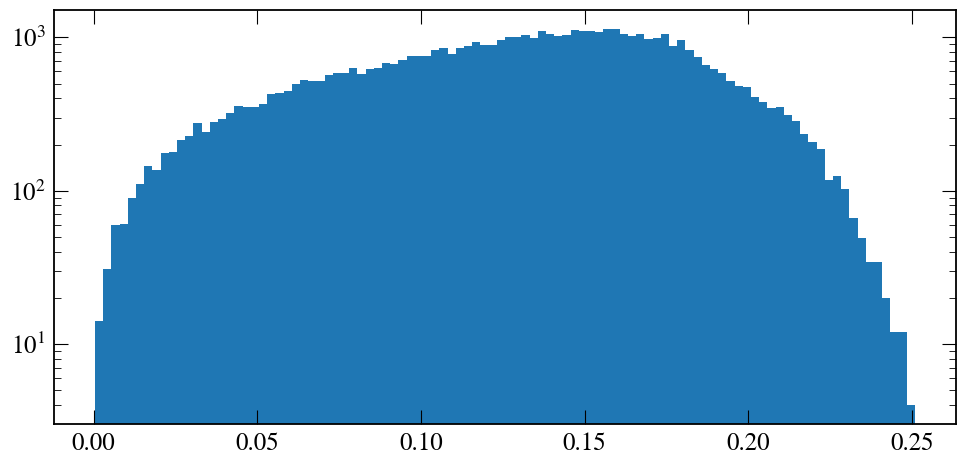

In [369]:
plt.figure(figsize=(10,5))
plt.hist(tg_sgr['dist_arcsec'], bins=100)
plt.gca().set_yscale('log')

plt.tight_layout()

### Membership origin

In [628]:
sources = ['Ibata2024', 'Li2021', 'Shipp2019', 'Awad2024', 'Koposov2023', 'Chandra2022', 'Shipp2020',
           'Ferguson2022', 'Yang2023', 'Yang2022', 'Grillmair2022', 'Grillmair2019', 'Bonaca2020', 'Huang2019',
           'Vasiliev2021']

In [633]:
member_origin = {'20.0-1':[], '300S':['Ibata2024'], 'ATLAS-Aliqa Uma':['Ibata2024','Li2021','Shipp2019'],
                 'Acheron':[], 'Alpheus':[], 'Aquarius':[], 'C-10':['Ibata2024'], 'C-11':['Ibata2024'],
                 'C-12':['Ibata2024'], 'C-13':['Ibata2024'], 'C-19':['Ibata2024'], 'C-20':['Ibata2024'],
                 'C-22':['Ibata2024'], 'C-23':['Ibata2024'], 'C-24':['Ibata2024'], 'C-25':['Ibata2024'], 'C-4':[],
                 'C-5':[], 'C-7':['Ibata2024'], 'C-8':[], 'C-9':['Ibata2024'], 'Cetus-Palca':['Li2021'],
                 'Cocytos':[], 'Corvus':[], 'Elqui':['Shipp2019'], 'Eridanus':[],
                 'GD-1':['Huang2019','Bonaca2020','Ibata2024'], 'Gaia-1':['Ibata2024'], 'Gaia-11':['Ibata2024'],
                 'Gaia-12':['Ibata2024'], 'Gaia-2':[], 'Gaia-3':[], 'Gaia-4':[], 'Gaia-5':[], 'Gaia-6':['Ibata2024'],
                 'Gaia-7':['Ibata2024'], 'Gaia-8':['Ibata2024'], 'Gaia-9':['Ibata2024'], 'Gunnthra':[], 'Hermus':[],
                 'Hrid':['Ibata2024'], 'Hydrus':['Ibata2024'], 'Hyllus':[], 'Indus':['Ibata2024', 'Shipp2019'],
                 'Jet':['Ferguson2022'], 'Jhelum':['Ibata2024','Shipp2019','Awad2024'], 'Kshir':['Ibata2024'],
                 'Kwando':['Ibata2024'], 'Wukong':['Ibata2024'], 'Leiptr':['Ibata2024'], 'Lethe':[],
                 'M2':['Grillmair2022', 'Ibata2024'], 'M3':['Ibata2024','Yang2023'], 'M30':['Ibata2024'],
                 'M5':['Grillmair2019','Ibata2024'], 'M68':['Ibata2024'], 'M92':['Ibata2024'], 'Molonglo':[],
                 'Murrumbidgee':[], 'NGC 1261':['Ibata2024'], 'NGC 1851':['Ibata2024'], 'NGC 2298':['Ibata2024'],
                 'NGC 2808':['Ibata2024'], 'NGC 288':['Ibata2024'], 'NGC 3201':['Ibata2024'], 'NGC 5053':[],
                 'NGC 5466':['Ibata2024'], 'NGC 6101':['Ibata2024'], 'NGC 6362':[], 'NGC 6397':['Ibata2024'],
                 'NGC 7492':['Ibata2024'], 'New-1':['Ibata2024'], 'New-10':['Ibata2024'],
                 'New-11':['Ibata2024'], 'New-12':['Ibata2024'], 'New-13':['Ibata2024'], 'New-14':['Ibata2024'],
                 'New-15':['Ibata2024'], 'New-16':['Ibata2024'], 'New-17':['Ibata2024'], 'New-18':['Ibata2024'],
                 'New-19':['Ibata2024'], 'New-2':['Ibata2024'], 'New-20':['Ibata2024'], 'New-21':['Ibata2024'],
                 'New-22':['Ibata2024'], 'New-23':['Ibata2024'], 'New-24':['Ibata2024'], 'New-25':['Ibata2024'],
                 'New-26':['Ibata2024'], 'New-27':['Ibata2024'], 'New-3':['Ibata2024'], 'New-4':['Ibata2024'],
                 'New-5':['Ibata2024'], 'New-6':['Ibata2024'], 'New-7':['Ibata2024'], 'New-8':['Ibata2024'],
                 'New-9':['Ibata2024'], 'Omega Centauri':['Ibata2024'], 'Ophiuchus':['Ibata2024'], 'Orinoco':[],
                 'Orphan-Chenab':['Shipp2019','Ibata2024','Koposov2023'], 'PS1-A':[], 'PS1-B':[], 'PS1-C':[],
                 'PS1-D':[], 'PS1-E':[], 'Palomar 13':['Shipp2020'], 'Palomar 15':[], 'Palomar 5':['Ibata2024'],
                 'Parallel':[], 'Pegasus':[], 'Perpendicular':[], 'Phlegethon':['Ibata2024'],
                 'Phoenix':['Ibata2024','Shipp2019'], 'Ravi':[], 'SGP-S':['Ibata2024'], 'Sagittarius':['Vasiliev2021'],
                 'Sangarius':[], 'Scamander':[], 'Slidr':['Ibata2024'], 'Spectre':['Chandra2022'], 'Styx':[],
                 'Sylgr':['Ibata2024'], 'Triangulum':['Yang2022'], 'Tucana III':['Ibata2024','Shipp2019'],
                 'Turbio':[], 'Turranburra':['Shipp2019'], 'Wambelong':[], 'Willka Yaku':[], 'Ylgr':['Ibata2024']}

In [634]:
nmem = 0
for k in member_origin.keys():
    if len(member_origin[k])>0: nmem += 1
print(nmem, len(member_origin.keys()), len(names))

91 131 131


## Membership catalogs

From individual data sets get: Gaia (DR3) source_id, and optionally: Vr, Vr_err, FeH, FeH_err, aFe, aFe_err, p_mem

From Gaia DR3 get: ra, dec, pmra, pmra_error, pmdec, pmdec_error

Calculate: d_orb, X, Y, Z, V_x, V_y, V_z

### Literature input catalogs

In [715]:
def input_stream(stream, catalog):
    """Load published members of a given stream from literature tables"""
    
    # define output table
    colnames = ('source_id', 'dist', 'dist_err', 'Vr', 'Vr_err', 'FeH', 'FeH_err', 'aFe', 'aFe_err', 'p_mem')
    tout = Table(names=colnames)
    tout['source_id'] = tout['source_id'].astype(int)
    
    if catalog=='Ibata2024':
        tin = Table.read('../data/members/input/ibata_apj_labeled.fits')
        sids = dict_invibata[stream]
        
        for sid in sids:
            ind_stream = tin['name']==sid
            t_ = tin[ind_stream]
            col_empty = np.ones(len(t_)) * np.nan
                        
            # set missing velocities to nans
            ind_novel = (t_['VHel']==0) & (t_['e_VHel']==300)
            t_['VHel'][ind_novel] = np.nan
            t_['e_VHel'][ind_novel] = np.nan
            
            # construct table
            tfill = Table([t_['Gaia'], col_empty, col_empty, t_['VHel'].value, t_['e_VHel'].value,
                          col_empty, col_empty, col_empty, col_empty, col_empty], names=colnames)
            tout = vstack([tout, tfill])
        
        # keep only unique rows (turns out in NGC 1261a and b there are duplicates..)
        tout = unique(tout, keys=['source_id'], keep='last')
        
    elif catalog=='Li2021':
        if stream=='Cetus-Palca':
            # RV members
            tin = Table.read('../data/members/input/palca_rv_li.csv', format='ascii.commented_header').filled(np.nan)
            col_empty = np.ones(len(tin)) * np.nan

            # construct table
            tout = Table([tin['Gaia Source ID'], col_empty, col_empty, tin['RV'], tin['RVerr'],
                          tin['FeH'], tin['FeHerr'], col_empty, col_empty, col_empty], names=colnames)
            
        elif stream=='ATLAS-Aliqa Uma':
            # RV members
            tin = Table.read('../data/members/input/aau_rv_li.csv', format='ascii.commented_header').filled(np.nan)
            col_empty = np.ones(len(tin)) * np.nan

            # construct table
            tout = Table([tin['Gaia Source ID'], col_empty, col_empty, tin['RV'], tin['RVerr'],
                          tin['FeH'], tin['FeHerr'], col_empty, col_empty, col_empty], names=colnames)
            
            # distance members
            tin = Table.read('../data/members/input/aau_dist_li.csv')
            col_empty = np.ones(len(tin)) * np.nan
            dist = 10**(0.2*tin['distance_modulus']+1) * 1e-3
            
            # sure there is a better way...
            for i in range(len(tin)):
                ind_ = tout['source_id'] == tin['source_id'][i]
                tout['dist'][ind_] = dist[i]
            
        # possibly Gaia DR2 ids?
        # match Gaia DR2 ids to DR3
        dr2_ids_str = ','.join(str(sid) for sid in tout['source_id'])
        query_dr23 = f"""SELECT * from gaiadr3.dr2_neighbourhood WHERE dr2_source_id IN ({dr2_ids_str})"""
        job = Gaia.launch_job(query_dr23)
        qmatch = job.get_results()
        tout['source_id'] = qmatch['dr3_source_id']
            

    elif catalog=='Shipp2019':
        # S5 DR1 for cross-matching radial velocities and metallicities
        ts5 = Table.read('../data/members/input/s5_unique.fits').filled(np.nan)
        ts5.rename_column('gaia_source_id', 'Gaia_Source_ID')
        
        # Shipp proper motion members
        tin = Table.read('../data/members/input/s5_shipp.txt', format='ascii.commented_header', delimiter=',')
        sids = dict_invshipp[stream]
                
        for sid in sids:
            ind_stream = tin['Stream']==sid
            # match S5 DR1
            t_ = join(tin[ind_stream], ts5, keys='Gaia_Source_ID', join_type='left')
            col_empty = np.ones(len(t_)) * np.nan
            
            # construct table
            tfill = Table([t_['Gaia_Source_ID'], col_empty, col_empty, t_['vel_calib'].value,
                           t_['vel_calib_std'].value,
                           t_['feh50'], t_['feh_calib_std'], col_empty, col_empty, t_['P_mem']], names=colnames)
            tout = vstack([tout, tfill.filled(np.nan)])
    
    elif (catalog=='Awad2024') & (stream=='Jhelum'):
        tin = Table.read('../data/members/input/jhelum_awad.txt', format='ascii', delimiter='\t').filled(np.nan)
        col_empty = np.ones(len(tin)) * np.nan
        
        tout = Table([tin['Gaia ID (Gaia DR3)'], col_empty, col_empty, tin['vrad (km/s)'], col_empty,
                     tin['[Fe/H]'], tin['FeHerr'], col_empty, col_empty, col_empty], names=colnames).filled(np.nan)
    
    elif (catalog=='Koposov2023') & (stream=='Orphan-Chenab'):
        tin = Table.read('../data/members/input/oc_koposov_unique.fits')
        col_empty = np.ones(len(tin)) * np.nan
        
        tout = Table([tin['source_id'], col_empty, col_empty, tin['rv'], tin['erv'],
                     col_empty, col_empty, col_empty, col_empty, col_empty], names=colnames)
    
    elif (catalog=='Chandra2022') & (stream=='Spectre'):
        tin = Table.read('../data/members/input/spectre_chandra_trim.txt', format='ascii', delimiter='\t')
        col_empty = np.ones(len(tin)) * np.nan
        
        tout = Table([tin['source_id'], col_empty, col_empty, tin['Vr'], tin['Vr_err'],
                     tin['feh'], tin['feh_err'], tin['afe'], tin['afe_err'], col_empty], names=colnames)
    
    elif (catalog=='Shipp2020') & (stream=='Palomar 13'):
        # The Gaia DR2 source_ids for the RRLs are 2814894112367752192, 2814893910504601600,
        # 2811888666052959232 (cluster) and 2712246494232725120, 2815432636842520960, 2705495870795198464 (tails).

        # tail RR Lyrae
        rrl_dr2_ids = np.array([2712246494232725120, 2815432636842520960, 2705495870795198464])
        
        # match Gaia DR2 ids to DR3
        dr2_ids_str = ','.join(str(sid) for sid in rrl_dr2_ids)
        query_dr23 = f"""SELECT * from gaiadr3.dr2_neighbourhood WHERE dr2_source_id IN ({dr2_ids_str})"""
        job = Gaia.launch_job(query_dr23)
        qmatch = job.get_results()
        
        # construct table
        col_empty = np.ones(len(qmatch)) * np.nan
        tout = Table([qmatch['dr3_source_id'], col_empty, col_empty, col_empty, col_empty,
                     col_empty, col_empty, col_empty, col_empty, col_empty], names=colnames)
    
    elif (catalog=='Ferguson2022') & (stream=='Jet'):
        tin = Table.read('../data/members/input/jet_ferguson.fits')
        col_empty = np.ones(len(tin)) * np.nan
        
        tout = Table([tin['Gaia'], tin['Dist'], col_empty, col_empty, col_empty,
                     col_empty, col_empty, col_empty, col_empty, col_empty], names=colnames)
    
    elif (catalog=='Yang2023') & (stream=='M3'):
        tin = Table.read('../data/members/input/m3_yang_trim.txt', format='ascii', delimiter='\t')
        col_empty = np.ones(len(tin)) * np.nan
        
        tout = Table([tin['source_id'], col_empty, col_empty, tin['Vr'], tin['Vr_err'],
                     tin['feh'], tin['feh_err'], col_empty, col_empty, col_empty], names=colnames)
    
    elif (catalog=='Yang2022') & (stream=='Triangulum'):
        tin = Table.read('../data/members/input/triangulum_yang_id.fits')
        col_empty = np.ones(len(tin)) * np.nan
        
        tout = Table([tin['source_id'], col_empty, col_empty, tin['Vr'], tin['Vr_err'],
                     tin['feh'], tin['feh_err'], col_empty, col_empty, col_empty], names=colnames)
    
    elif (catalog=='Grillmair2022') & (stream=='M2'):
        tin = Table.read('../data/members/input/m2_grillmair_id.fits')
        col_empty = np.ones(len(tin)) * np.nan
        
        tout = Table([tin['source_id'], col_empty, col_empty, col_empty, col_empty,
                     col_empty, col_empty, col_empty, col_empty, tin['Weight']], names=colnames)
    
    elif (catalog=='Grillmair2019') & (stream=='M5'):
        tin = Table.read('../data/members/input/m5_grillmair_id.fits')
        col_empty = np.ones(len(tin)) * np.nan
        
        tout = Table([tin['source_id'], col_empty, col_empty, col_empty, col_empty,
                     col_empty, col_empty, col_empty, col_empty, tin['w']], names=colnames)
    
    elif (catalog=='Bonaca2020') & (stream=='GD-1'):
        tin = Table.read('../data/members/input/gd1_bonaca.fits')
        tin = tin[tin['mem']]
        
        # match Gaia DR2 ids to DR3
        dr2_ids_str = ','.join(str(sid) for sid in tin['source_id'])
        query_dr23 = f"""SELECT * from gaiadr3.dr2_neighbourhood WHERE dr2_source_id IN ({dr2_ids_str})"""
        job = Gaia.launch_job(query_dr23)
        qmatch = job.get_results()
        
        # construct table
        col_empty = np.ones(len(qmatch)) * np.nan
        tout = Table([qmatch['dr3_source_id'], tin['Dist'].value, tin['std_Dist'].value, tin['Vrad'].value, 
                      tin['std_Vrad'].value,
                     tin['FeH'], tin['std_FeH'], tin['aFe'], tin['std_aFe'], col_empty], names=colnames)
    
    elif (catalog=='Huang2019') & (stream=='GD-1'):
        tin = Table.read('../data/members/input/gd1_huang_id.fits')
        col_empty = np.ones(len(tin)) * np.nan
        
        tout = Table([tin['source_id'], col_empty, col_empty, tin['vr'].value, tin['err'].value,
                     col_empty, col_empty, col_empty, col_empty, col_empty], names=colnames)
    
    elif (catalog=='Vasiliev2021') & (stream=='Sagittarius'):
        tin = Table.read('../data/members/input/sgr_vasiliev_adql.fits')
        tin_id = Table.read('../data/members/input/sgr_vasiliev_ids.gz')
        col_empty = np.ones(len(tin)) * np.nan
        
        # set missing velocities to nans
        ind_novel = (tin['vLOS']==0) & (tin['e_vLOS']==0)
        tin['vLOS'][ind_novel] = np.nan
        tin['e_vLOS'][ind_novel] = np.nan
        
        # set missing metallicities to nans
        ind_nofeh = (tin['FeH']==0) & (tin['e_FeH']==0)
        tin['FeH'][ind_nofeh] = np.nan
        tin['e_FeH'][ind_nofeh] = np.nan
        
        tout = Table([tin_id['source_id'], tin['Dist'], tin['e_Dist'], tin['vLOS'], tin['e_vLOS'],
                     tin['FeH'], tin['e_FeH'], col_empty, col_empty, col_empty], names=colnames)
    
    print(stream, catalog, len(tout), np.size(np.unique(tout['source_id'])))
    
    # sort by the source_id to allow hstacking the Gaia query
    tout.sort(['source_id'])
    
    # look up Gaia DR3 
    ids_str = ','.join(str(sid) for sid in tout['source_id'])
    query_gaia = f"""SELECT ra, dec, pmra, pmra_error, pmdec, pmdec_error
    FROM gaiadr3.gaia_source WHERE source_id IN ({ids_str})"""
    
    job = Gaia.launch_job(query_gaia)
    qmatch = job.get_results()
    tout = hstack([tout, qmatch])
        
    # set units
    tout['dist'] = tout['dist'] * u.kpc
    tout['dist_err'] = tout['dist_err'] * u.kpc
    tout['Vr'] = tout['Vr'] * u.km/u.s
    tout['Vr_err'] = tout['Vr_err'] * u.km/u.s
    
    # add stream and reference columns
    tout['name'] = [stream for x in range(len(tout))]
    tout['reference'] = [catalog for x in range(len(tout))]
    
    return tout

In [718]:
# test
input_stream('Tucana III', 'Ibata2024')

Tucana III Ibata2024 102 102


source_id,dist,dist_err,Vr,Vr_err,FeH,FeH_err,aFe,aFe_err,p_mem,ra,dec,pmra,pmra_error,pmdec,pmdec_error,name,reference
,kpc,kpc,km / s,km / s,,,,,,deg,deg,mas / yr,mas / yr,mas / yr,mas / yr,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float32,str10,str9
4903607150172004352,nan,nan,nan,nan,nan,nan,nan,nan,nan,9.882412625372645,-60.61317460883847,0.17774640335485836,0.0528868,-1.4281262136743464,0.05188244,Tucana III,Ibata2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6504095922405335424,nan,nan,nan,nan,nan,nan,nan,nan,nan,340.95197425733585,-57.50106699928668,-1.2317032228773672,0.124554984,-1.7970706498587088,0.16535746,Tucana III,Ibata2024


### Create all stream tables

In [719]:
for stream in names[:]:
    print(stream)
    catalogs = member_origin[stream]
    for e, catalog in enumerate(catalogs):
        t_ = input_stream(stream, catalog)
        
        if e==0:
            tout = t_
        else:
            tout = vstack([tout, t_])
    
        tout.write('../data/members/streams/{:s}.fits'.format(stream), overwrite=True)

20.0-1
300S
300S Ibata2024 141 141
ATLAS-Aliqa Uma
ATLAS-Aliqa Uma Ibata2024 208 208
ATLAS-Aliqa Uma Li2021 96 96


ATLAS-Aliqa Uma Shipp2019 30 30
Acheron
Alpheus
Aquarius
C-10
C-10 Ibata2024 158 158
C-11
C-11 Ibata2024 112 112
C-12
C-12 Ibata2024 929 929
C-13
C-13 Ibata2024 100 100
C-19
C-19 Ibata2024 46 46
C-20
C-20 Ibata2024 29 29
C-22
C-22 Ibata2024 39 39
C-23
C-23 Ibata2024 29 29
C-24
C-24 Ibata2024 244 244
C-25
C-25 Ibata2024 121 121
C-4
C-5
C-7
C-7 Ibata2024 239 239
C-8
C-9
C-9 Ibata2024 183 183
Cetus-Palca
Cetus-Palca Li2021 25 25
Cocytos
Corvus
Elqui
Elqui Shipp2019 17 17
Eridanus
GD-1
GD-1 Huang2019 67 67
GD-1 Bonaca2020 43 43


GD-1 Ibata2024 1468 1468


Gaia-1
Gaia-1 Ibata2024 200 200
Gaia-11
Gaia-11 Ibata2024 84 84
Gaia-12
Gaia-12 Ibata2024 46 46
Gaia-2
Gaia-3
Gaia-4
Gaia-5
Gaia-6
Gaia-6 Ibata2024 145 145
Gaia-7
Gaia-7 Ibata2024 282 282
Gaia-8
Gaia-8 Ibata2024 453 453
Gaia-9
Gaia-9 Ibata2024 233 233
Gunnthra
Hermus
Hrid
Hrid Ibata2024 666 666
Hydrus
Hydrus Ibata2024 39 39
Hyllus
Indus
Indus Ibata2024 1021 1021
Indus Shipp2019 25 25
Jet
Jet Ferguson2022 144 144
Jhelum
Jhelum Ibata2024 986 986
Jhelum Shipp2019 22 22
Jhelum Awad2024 22 22
Kshir
Kshir Ibata2024 141 141
Kwando
Kwando Ibata2024 138 138
Wukong
Wukong Ibata2024 358 358
Leiptr
Leiptr Ibata2024 412 412
Lethe
M2
M2 Grillmair2022 125 125
M2 Ibata2024 15 15


M3
M3 Ibata2024 234 234
M3 Yang2023 11 11
M30
M30 Ibata2024 54 54
M5
M5 Grillmair2019 50 50
M5 Ibata2024 91 91


M68
M68 Ibata2024 297 297
M92
M92 Ibata2024 202 202
Molonglo
Murrumbidgee
NGC 1261
NGC 1261 Ibata2024 174 174
NGC 1851
NGC 1851 Ibata2024 105 105
NGC 2298
NGC 2298 Ibata2024 125 125
NGC 2808
NGC 2808 Ibata2024 292 292
NGC 288
NGC 288 Ibata2024 173 173
NGC 3201
NGC 3201 Ibata2024 607 607
NGC 5053
NGC 5466
NGC 5466 Ibata2024 43 43
NGC 6101
NGC 6101 Ibata2024 94 94
NGC 6362
NGC 6397
NGC 6397 Ibata2024 1207 1207
NGC 7492
NGC 7492 Ibata2024 26 26
New-1
New-1 Ibata2024 11 11
New-10
New-10 Ibata2024 47 47
New-11
New-11 Ibata2024 18 18
New-12
New-12 Ibata2024 89 89
New-13
New-13 Ibata2024 47 47
New-14
New-14 Ibata2024 18 18
New-15
New-15 Ibata2024 152 152
New-16
New-16 Ibata2024 44 44
New-17
New-17 Ibata2024 13 13
New-18
New-18 Ibata2024 107 107
New-19
New-19 Ibata2024 40 40
New-2
New-2 Ibata2024 90 90
New-20
New-20 Ibata2024 12 12
New-21
New-21 Ibata2024 762 762
New-22
New-22 Ibata2024 55 55
New-23
New-23 Ibata2024 44 44
New-24
New-24 Ibata2024 56 56
New-25
New-25 Ibata2024 121 121
New-26
New

Sangarius
Scamander
Slidr
Slidr Ibata2024 330 330
Spectre
Spectre Chandra2022 6 6
Styx
Sylgr
Sylgr Ibata2024 256 256
Triangulum
Triangulum Yang2022 27 27
Tucana III
Tucana III Ibata2024 102 102
Tucana III Shipp2019 23 23
Turbio
Turranburra
Turranburra Shipp2019 11 11
Wambelong
Willka Yaku
Ylgr
Ylgr Ibata2024 919 919


In [720]:
# check for duplicates
print('same catalog')
for stream in names[:]:
    catalogs = member_origin[stream]

    if len(catalogs)==1:
        tall = Table.read('../data/members/streams/{:s}.fits'.format(stream))
        ntot = len(tall)
        nunique = np.size(np.unique(tall['source_id']))
        
        if (ntot != nunique):
            print(stream, ntot, nunique, ntot-nunique, len(catalogs))
        
            unique, counts = np.unique(tall['source_id'], return_counts=True)
            duplicates = unique[counts>1]
            for i_ in duplicates:
                ind = tall['source_id']==i_
                print(tall['Vr'][ind], tall['Vr_err'][ind])

print('\ndifferent catalogs')
for stream in names[:]:
    catalogs = member_origin[stream]

    if len(catalogs)>1:
        tall = Table.read('../data/members/streams/{:s}.fits'.format(stream))
        ntot = len(tall)
        nunique = np.size(np.unique(tall['source_id']))
        
        print(stream, ntot, nunique, ntot-nunique, len(catalogs))

same catalog



different catalogs
ATLAS-Aliqa Uma 334 245 89 3
GD-1 1578 1478 100 3
Indus 1046 1032 14 2
Jhelum 1030 1007 23 3
M2 140 136 4 2
M3 245 237 8 2
M5 141 128 13 2
Orphan-Chenab 1212 1037 175 3
Phoenix 71 60 11 2
Tucana III 125 106 19 2


In [607]:
# # create catalogs of unique Gaia stars
# for stream in names[:]:
#     fin = '../data/members/streams/{:s}.fits'.format(stream)
#     fout = '../data/members/unique/{:s}_unique.fits'.format(stream)
    
#     catalogs = member_origin[stream]
    
#     if len(catalogs)>1:
#         # find unique members
#         tall = Table.read(fin)
    
#     else:
#         # copy existing catalog to a new directory
#         os.system(f'cp {fin} {fout}')


### Single table for all members

In [721]:
# list of streams with published members
published = []
for stream in names[:]:
    catalogs = member_origin[stream]

    if len(catalogs)>0:
        published += [stream]

In [722]:
for e, stream in enumerate(published):
    print(stream)
    t1 = Table.read('../data/members/streams/{:s}.fits'.format(stream))
    
    if e==0:
        tall = t1
    else:
        tall = vstack([tall, t1])

tall.write('../data/members/all_streams.fits', overwrite=True)

300S
ATLAS-Aliqa Uma
C-10
C-11
C-12
C-13
C-19
C-20


C-22
C-23
C-24
C-25
C-7
C-9
Cetus-Palca
Elqui
GD-1
Gaia-1
Gaia-11
Gaia-12
Gaia-6
Gaia-7
Gaia-8
Gaia-9
Hrid
Hydrus
Indus
Jet
Jhelum
Kshir
Kwando
Wukong
Leiptr
M2
M3


M30
M5
M68
M92
NGC 1261
NGC 1851
NGC 2298
NGC 2808
NGC 288
NGC 3201
NGC 5466
NGC 6101
NGC 6397
NGC 7492
New-1
New-10
New-11
New-12
New-13
New-14
New-15
New-16
New-17
New-18
New-19
New-2
New-20
New-21
New-22
New-23
New-24
New-25
New-26
New-27
New-3
New-4
New-5
New-6
New-7
New-8
New-9
Omega Centauri
Ophiuchus
Orphan-Chenab
Palomar 13
Palomar 5
Phlegethon
Phoenix
Sagittarius
Slidr


Spectre
Sylgr
Triangulum
Tucana III
Turranburra
Ylgr


In [723]:
tall

source_id,dist,dist_err,Vr,Vr_err,FeH,FeH_err,aFe,aFe_err,p_mem,ra,dec,pmra,pmra_error,pmdec,pmdec_error,name,reference
,kpc,kpc,km / s,km / s,[-],[-],,,,deg,deg,mas / yr,mas / yr,mas / yr,mas / yr,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float32,bytes15,bytes13
614929674862467712,--,--,--,--,--,--,--,--,--,150.33340244295138,13.24963486472028,-2.911746254015053,0.27712572,-2.8591656877612537,0.20834441,300S,Ibata2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6151097027112747392,--,--,--,--,--,--,--,--,--,183.37829974024262,-39.023053497398344,-0.050227603080344574,0.17965835,-4.956822965162361,0.16273545,Ylgr,Ibata2024


## Figure: Sky positions of published stream members

In [724]:
print(names)

['20.0-1', '300S', 'ATLAS-Aliqa Uma', 'Acheron', 'Alpheus', 'Aquarius', 'C-10', 'C-11', 'C-12', 'C-13', 'C-19', 'C-20', 'C-22', 'C-23', 'C-24', 'C-25', 'C-4', 'C-5', 'C-7', 'C-8', 'C-9', 'Cetus-Palca', 'Cocytos', 'Corvus', 'Elqui', 'Eridanus', 'GD-1', 'Gaia-1', 'Gaia-11', 'Gaia-12', 'Gaia-2', 'Gaia-3', 'Gaia-4', 'Gaia-5', 'Gaia-6', 'Gaia-7', 'Gaia-8', 'Gaia-9', 'Gunnthra', 'Hermus', 'Hrid', 'Hydrus', 'Hyllus', 'Indus', 'Jet', 'Jhelum', 'Kshir', 'Kwando', 'Wukong', 'Leiptr', 'Lethe', 'M2', 'M3', 'M30', 'M5', 'M68', 'M92', 'Molonglo', 'Murrumbidgee', 'NGC 1261', 'NGC 1851', 'NGC 2298', 'NGC 2808', 'NGC 288', 'NGC 3201', 'NGC 5053', 'NGC 5466', 'NGC 6101', 'NGC 6362', 'NGC 6397', 'NGC 7492', 'New-1', 'New-10', 'New-11', 'New-12', 'New-13', 'New-14', 'New-15', 'New-16', 'New-17', 'New-18', 'New-19', 'New-2', 'New-20', 'New-21', 'New-22', 'New-23', 'New-24', 'New-25', 'New-26', 'New-27', 'New-3', 'New-4', 'New-5', 'New-6', 'New-7', 'New-8', 'New-9', 'Omega Centauri', 'Ophiuchus', 'Orinoco',

In [725]:
mwstreams.keys()

dict_keys(['20.0-1-M18', '300S-F18', 'AAU-ATLAS-L21', 'AAU-AliqaUma-L21', 'ACS-R21', 'Acheron-G09', 'Alpheus-G13', 'Aquarius-W11', 'C-10-I24', 'C-11-I24', 'C-12-I24', 'C-13-I24', 'C-19-I21', 'C-20-I24', 'C-22-I24', 'C-23-I24', 'C-24-I24', 'C-25-I24', 'C-4-I21', 'C-5-I21', 'C-7-I21', 'C-8-I21', 'C-9-I24', 'Cetus-New-Y21', 'Cetus-Palca-T21', 'Cetus-Y13', 'Cocytos-G09', 'Corvus-M18', 'Elqui-S19', 'Eridanus-M17', 'GD-1-I21', 'Gaia-1-I21', 'Gaia-10-I21', 'Gaia-11-I21', 'Gaia-12-I21', 'Gaia-2-I21', 'Gaia-3-M18', 'Gaia-4-M18', 'Gaia-5-M18', 'Gaia-6-I21', 'Gaia-7-I21', 'Gaia-8-I21', 'Gaia-9-I21', 'Gunnthra-I21', 'Hermus-G14', 'Hrid-I21', 'Hydrus-I24', 'Hyllus-G14', 'Indus-S19', 'Jet-F22', 'Jhelum-a-B19', 'Jhelum-b-B19', 'Kshir-I21', 'Kwando-I21', 'LMS1-Y20', 'Leiptr-I21', 'Lethe-G09', 'M2-I21', 'M3-Y23', 'M30-S20', 'M5-G19', 'M68-P19', 'M92-I21', 'Molonglo-G17', 'Monoceros-R21', 'Murrumbidgee-G17', 'NGC1261-I21', 'NGC1261a-I24', 'NGC1261b-I24', 'NGC1851-I21', 'NGC2298-I21', 'NGC288-I21', 'NGC3

In [726]:
# translate stream names to galstreams
dict_invgalstreams = {'20.0-1':'20.0-1-M18', '300S':'300S-F18', 'ATLAS-Aliqa Uma':'AAU-ATLAS-L21',
                      'Acheron':'Acheron-G09', 'Alpheus':'Alpheus-G13', 'Aquarius':'Aquarius-W11', 'C-10':'C-10-I24',
                      'C-11':'C-11-I24', 'C-12':'C-12-I24', 'C-13':'C-13-I24', 'C-19':'C-19-I21', 'C-20':'C-20-I24',
                      'C-22':'C-22-I24', 'C-23':'C-23-I24', 'C-24':'C-24-I24', 'C-25':'C-25-I24', 'C-4':'C-4-I21',
                      'C-5':'C-5-I21', 'C-7':'C-7-I21', 'C-8':'C-8-I21', 'C-9':'C-9-I24',
                      'Cetus-Palca':'Cetus-Palca-T21', 'Cocytos':'Cocytos-G09', 'Corvus':'Corvus-M18',
                      'Elqui':'Elqui-S19', 'Eridanus':'Eridanus-M17', 'GD-1':'GD-1-I21', 'Gaia-1':'Gaia-1-I21',
                      'Gaia-11':'Gaia-11-I21', 'Gaia-12':'Gaia-12-I21', 'Gaia-2':'Gaia-2-I21', 'Gaia-3':'Gaia-3-M18',
                      'Gaia-4':'Gaia-4-M18', 'Gaia-5':'Gaia-5-M18', 'Gaia-6':'Gaia-6-I21', 'Gaia-7':'Gaia-7-I21',
                      'Gaia-8':'Gaia-8-I21', 'Gaia-9':'Gaia-9-I21', 'Gunnthra':'Gunnthra-I21', 'Hermus':'Hermus-G14',
                      'Hrid':'Hrid-I21', 'Hydrus':'Hydrus-I24', 'Hyllus':'Hyllus-G14', 'Indus':'Indus-S19',
                      'Jet':'Jet-F22', 'Jhelum':'Jhelum-a-B19', 'Kshir':'Kshir-I21', 'Kwando':'Kwando-I21',
                      'Wukong':'LMS1-Y20', 'Leiptr':'Leiptr-I21', 'Lethe':'Lethe-G09', 'M2':'M2-I21', 'M3':'M3-Y23',
                      'M30':'M30-S20', 'M5':'M5-G19', 'M68':'M68-P19', 'M92':'M92-I21', 'Molonglo':'Molonglo-G17',
                      'Murrumbidgee':'Murrumbidgee-G17', 'NGC 1261':'NGC1261-I21', 'NGC 1851':'NGC1851-I21',
                      'NGC 2298':'NGC2298-I21', 'NGC 2808':'NGC2808-I24', 'NGC 288':'NGC288-I21',
                      'NGC 3201':'NGC3201-P21', 'NGC 5053':'NGC5053-L06', 'NGC 5466':'NGC5466-J21',
                      'NGC 6101':'NGC6101-I24', 'NGC 6362':'NGC6362-S20', 'NGC 6397':'NGC6397-I21',
                      'NGC 7492':'NGC7492-I24', 'New-1':'New-1-I24', 'New-10':'New-10-I24', 'New-11':'New-11-I24',
                      'New-12':'New-12-I24', 'New-13':'New-13-I24', 'New-14':'New-14-I24', 'New-15':'New-15-I24',
                      'New-16':'New-16-I24', 'New-17':'New-17-I24', 'New-18':'New-18-I24', 'New-19':'New-19-I24',
                      'New-2':'New-2-I24', 'New-20':'New-20-I24', 'New-21':'New-21-I24', 'New-22':'New-22-I24',
                      'New-23':'New-23-I24', 'New-24':'New-24-I24', 'New-25':'New-25-I24', 'New-26':'New-26-I24',
                      'New-27':'New-27-I24', 'New-3':'New-3-I24', 'New-4':'New-4-I24', 'New-5':'New-5-I24',
                      'New-6':'New-6-I24', 'New-7':'New-7-I24', 'New-8':'New-8-I24', 'New-9':'New-9-I24',
                      'Omega Centauri':'OmegaCen-I21', 'Ophiuchus':'Ophiuchus-C20', 'Orinoco':'Orinoco-G17',
                      'Orphan-Chenab':'Orphan-K23', 'PS1-A':'PS1-A-B16', 'PS1-B':'PS1-B-B16', 'PS1-C':'PS1-C-B16',
                      'PS1-D':'PS1-D-B16', 'PS1-E':'PS1-E-B16', 'Palomar 13':'Pal13-S20', 'Palomar 15':'Pal15-M17',
                      'Palomar 5':'Pal5-PW19', 'Parallel':'Parallel-W18', 'Pegasus':'Pegasus-P19',
                      'Perpendicular':'Perpendicular-W18', 'Phlegethon':'Phlegethon-I21', 'Phoenix':'Phoenix-S19',
                      'Ravi':'Ravi-S18', 'SGP-S':'SGP-S-Y22', 'Sagittarius':'Sagittarius-A20',
                      'Sangarius':'Sangarius-G17', 'Scamander':'Scamander-G17', 'Slidr':'Slidr-I21',
                      'Spectre':'Spectre-C22', 'Styx':'Styx-G09', 'Sylgr':'Sylgr-I21', 'Triangulum':'Tri-Pis-B12',
                      'Tucana III':'TucanaIII-S19', 'Turbio':'Turbio-S18', 'Turranburra':'Turranburra-S19',
                      'Wambelong':'Wambelong-S18', 'Willka Yaku':'Willka_Yaku-S18', 'Ylgr':'Ylgr-I21'}

In [729]:
# set up figure geometry
nstream = len(published)
ncol = 4
nrow = int(np.ceil(nstream/ncol))
print(nstream, nrow, ncol)

91 23 4


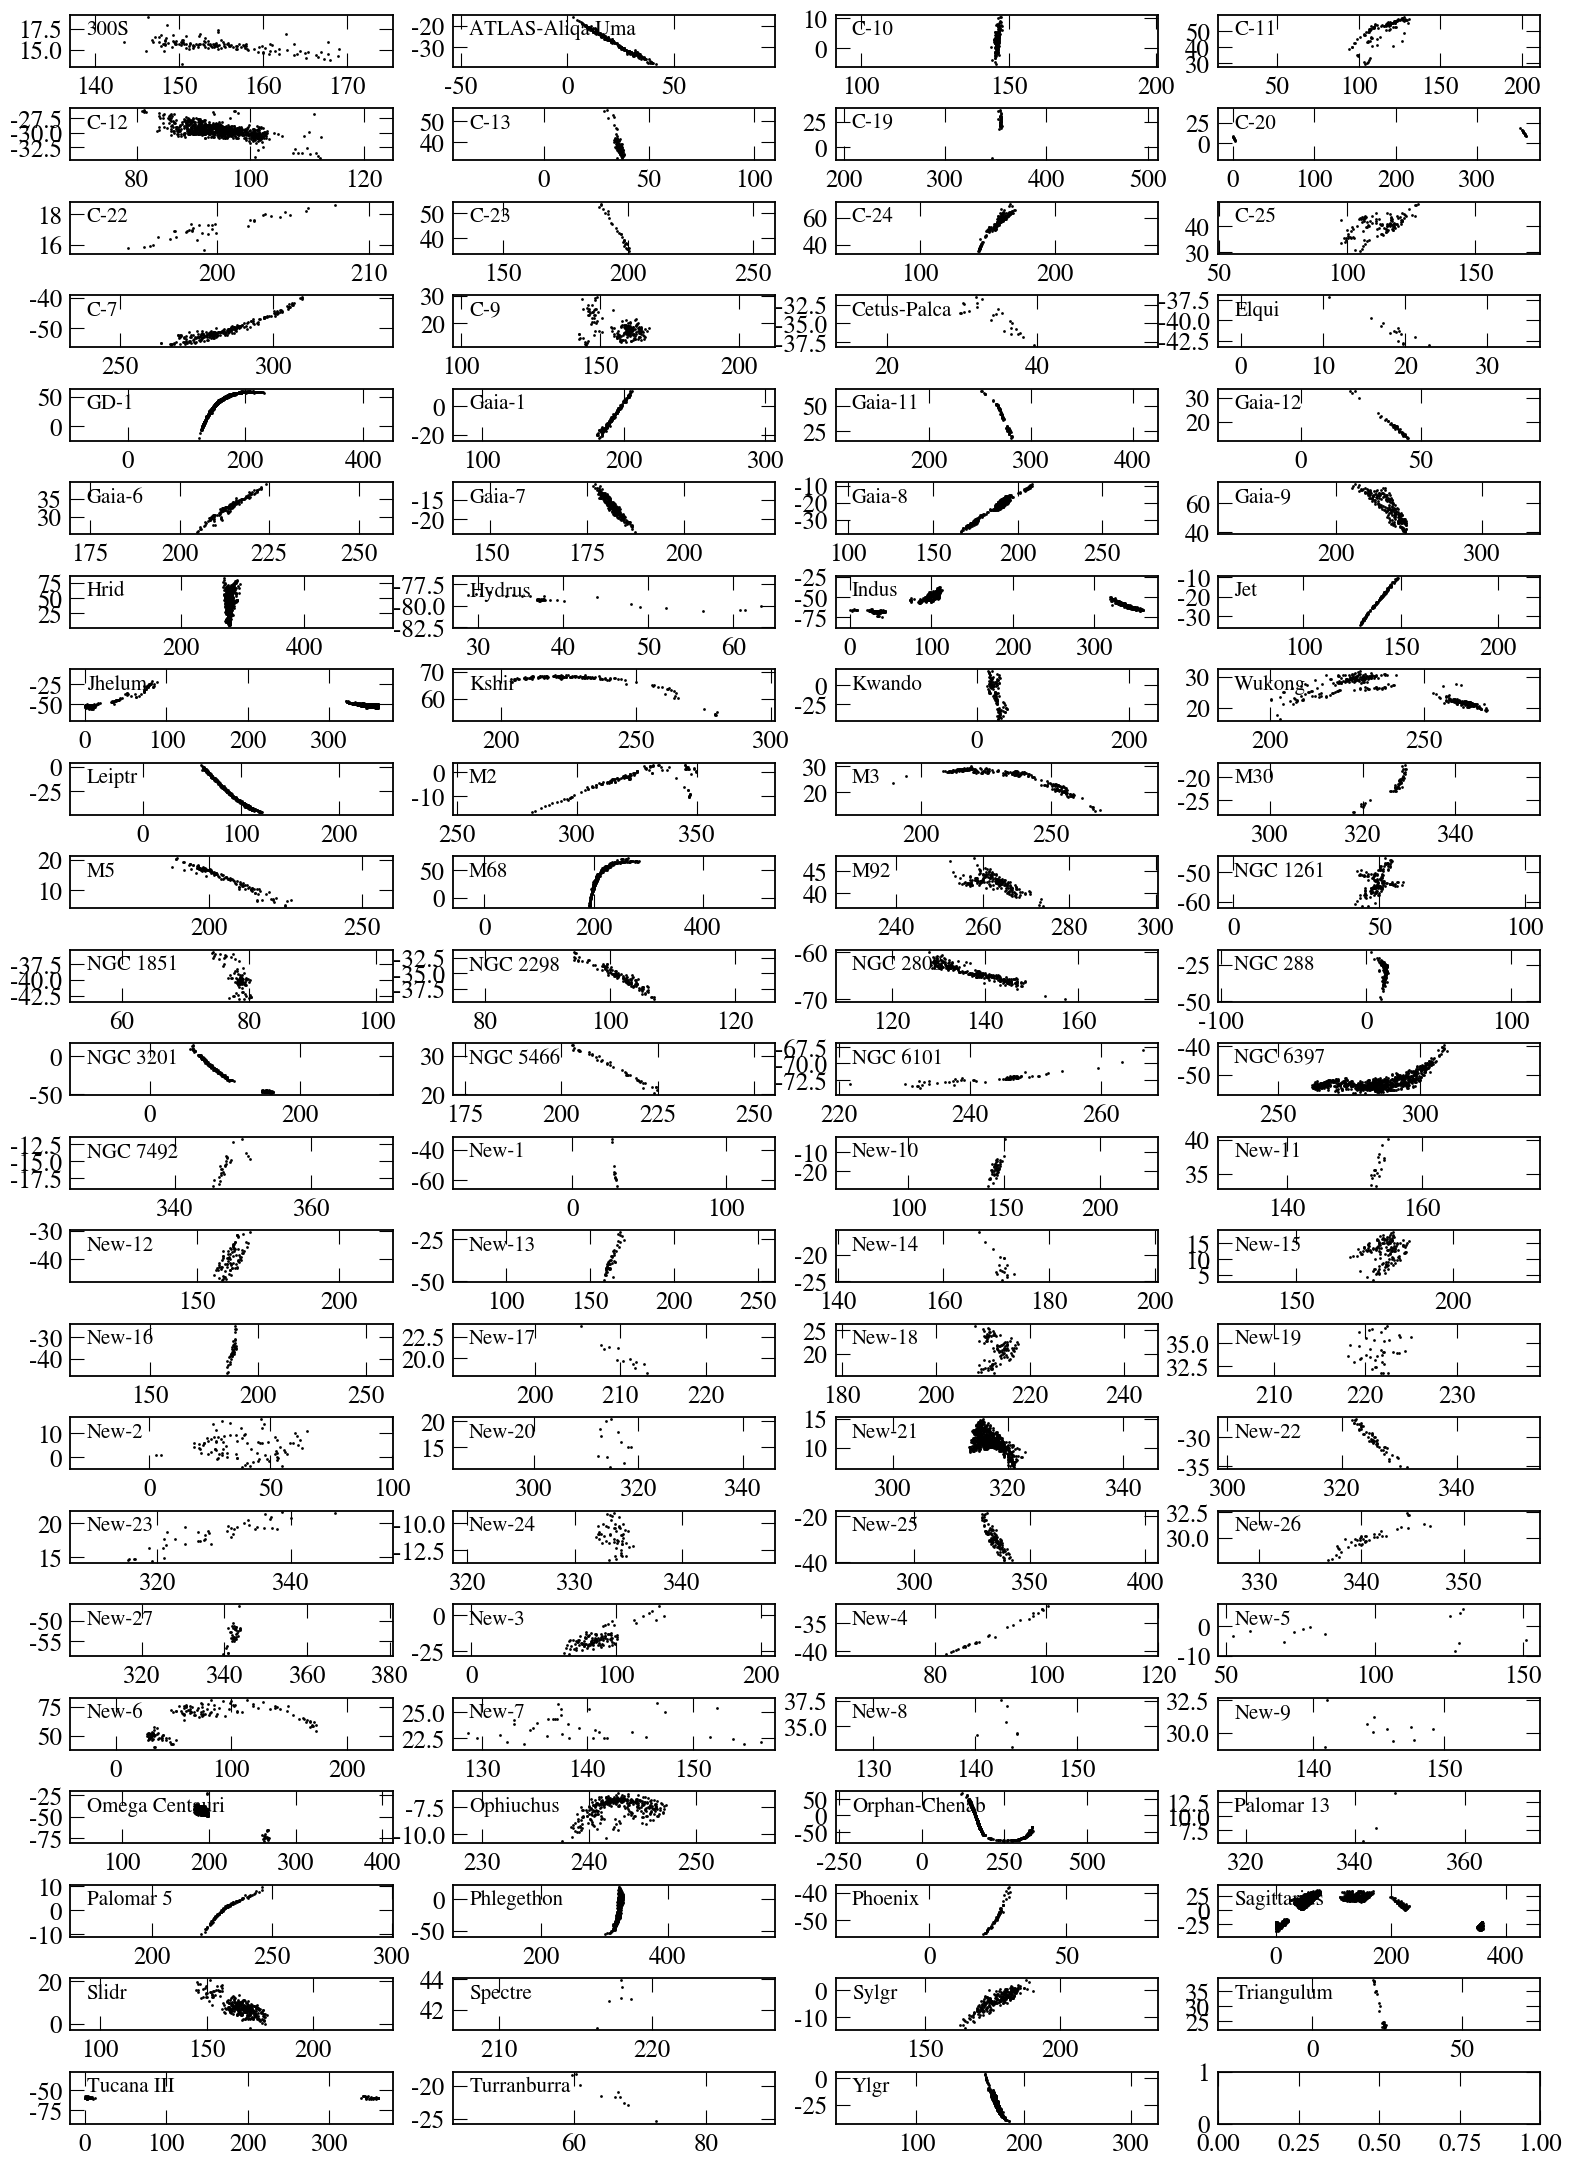

In [741]:

fig, ax = plt.subplots(nrow, ncol, figsize=(16,22))

for i in range(nstream):
    irow = i // ncol
    icol = i % ncol
    plt.sca(ax[irow][icol])
    
    ind_plot = tall['name']==published[i]
    c_ = coord.SkyCoord(ra=tall['ra'][ind_plot], dec=tall['dec'][ind_plot], frame='icrs')
    cs_ = c_.transform_to(mwstreams[dict_invgalstreams[published[i]]].stream_frame)
    
    plt.plot(cs_.phi1, cs_.phi2, 'ko', mew=0, ms=2, rasterized=True)
    
#     plt.plot(tall['ra'][ind_plot], tall['dec'][ind_plot], 'ko', mew=0, ms=2, rasterized=True)
    
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.text(0.05, 0.9, published[i], transform=plt.gca().transAxes, va='top', fontsize='small', alpha=0.3)
    
plt.tight_layout(h_pad=0, w_pad=0)
plt.savefig('../plots/all_members_sky.png', dpi=300)